# Foundations of Data Mining: Assignment 3
Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [3]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "none" 

##  Random Projections with 1-NN (6 points, 3+3)

Implement random projections for dimensionality reduction as follows.
Randomly generate a $k \times d$ matrix $\bf R$ by choosing its coefficients
$$
r_{i,j}=
\begin{cases}
+\frac{1}{{\sqrt{d}}} \quad \text{with probability}\quad &\frac{1}{2}\\
-\frac{1}{\sqrt{d}} \quad \text{with probability} \quad & \frac{1}{2}
\end{cases}
$$ 
Let $f:\mathbb{R}^d \rightarrow \mathbb{R}^k$ denote the linear mapping function that 
multiplies a $d$-dimensional vector with this matrix $f(p)={\bf R}p$.
For the following exercises use the same data set as was used for Assignment 1 (MNIST). 
Use the following values of $k=45,90,400$ in your experiments.  
You should _not_ use sklearn.random_projection for this assignment.


###  Study the effect on pairwise distances
Evaluate how well the Euclidean distance is preserved by plotting a histogram of the 
values $\phi(p,q) = \frac{\|f(p)-f(q)\|}{\|p-q\|}$ for all pairs of the first 500 images of the MNIST data set. These values should be concentrated around a certain value for fixed $k$. What is this value expressed in terms of $k$ and $d$? Explain your answer.


In [4]:
# We get our openML key from our local config

In [5]:
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
# Get the predictors X and the labels y
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute); 

In [6]:
import math

# Randomly generate coefficient with probability 1/2
def generateCoeff(d):
    p = np.random.randint(0,2)
    v = 1/math.sqrt(d)
    if (p):
        v *= -1
    return v

# Create random matrix R given k and d
def generateMatrix(k, d):
    data = []
    for i in range(k):
        row = []
        for j in range(d):
            row.append(generateCoeff(d))
        data.append(row)

    return np.matrix(data)

# Return kxd matrix multiplied with d-dimensional vector p
def f(R, p):
    return R * p

d = 784 k = 45 mean = 0.234505468509
d = 784 k = 90 mean = 0.339309047579
d = 784 k = 400 mean = 0.714128426092


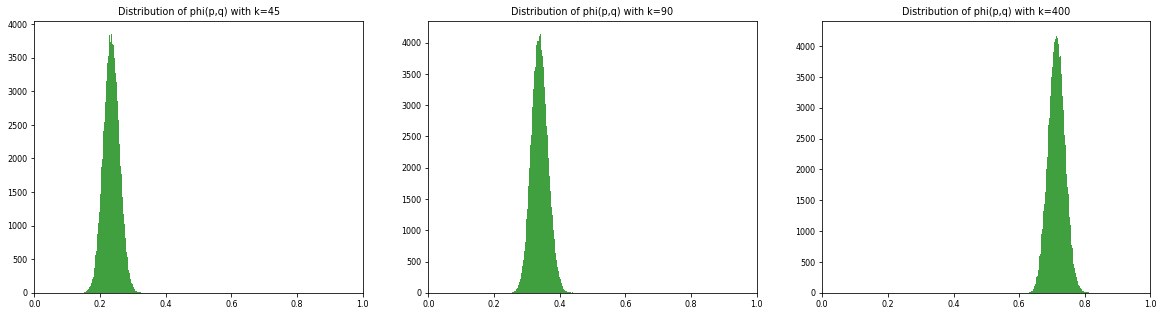

In [7]:
d = len(X[0]) # d is the amount of features
size = 500
    
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Run experiments
for k, testnr in zip([45, 90, 400], range(3)):
    R = generateMatrix(k, d)
    # Initialize phi
    phi = []
    for i in range(size):
        for j in range(i+1, size):
            # Loop over all pairs
            p = X[i]
            q = X[j]
            
            # Calculate linear mapping
            pf = f(R, np.transpose(np.matrix(p)))
            qf = f(R, np.transpose(np.matrix(q)))
            
            # Compute distances
            df = np.linalg.norm(pf-qf)
            dist = np.linalg.norm(p-q)
            
            # Append the result
            phi.append(df/dist)
            
    # Plot histograms
    print("d =", d, "k =", k ,"mean =", np.array(phi).mean())
    axes[testnr].hist(phi, 100, facecolor='green', alpha=0.75)
    axes[testnr].set_title("Distribution of phi(p,q) with k=%s" % k)
    axes[testnr].set_xlim(0, 1)

#### Results
It is very clearly visible that when we increase $k$, the distribution is shifted to the right (higher value). This implies that when increasing $k$, the ratio between the transformed distances and the original euclidian distance is higher.

Based on our results, it looks like the relation $f$ between $k$, $d$ and the mean of the distribution is defined as:
$f(k, d) = \frac{k}{d}$

Meaning the mean of the distribution $\overline{\phi} \approx 0$ when $k = 0$ and the $\overline{\phi} \approx 1$ when $k = d$ 

### Study the effect on classification
Compare the performance of a $1$-NN classifier with and without random projection. Report multi-class confusion matrix, precision and recall for each class with and without projection and for each value of $k$. Evaluate your findings with respect to the use of random projections and classification.

In [8]:
# Projects a dataset given a projection matrix
def random_projection(data, R):
    result = []
    for p in data:
        result.append( np.array(f(R, np.transpose(np.matrix(p)))).flatten() )
    return result

def print_results(y_test, y_pred, axis, project, k=-1):
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average="micro")
    precision = precision_score(y_test, y_pred, average="micro")
    
    if project:
        title = "RP=True k=%s recall=%s precision=%s" % (k, recall, precision)
    else:
        title = "RP=False recall=%s precision=%s" % (recall, precision)
    mglearn.tools.heatmap(cm, ax=axis,
                          xlabel='Predicted label',xticklabels=range(10),
                          ylabel='True label', yticklabels=range(10),
                          fmt="%d",
                          cmap="viridis");
    axis.set_title(title)
    axis.invert_yaxis()

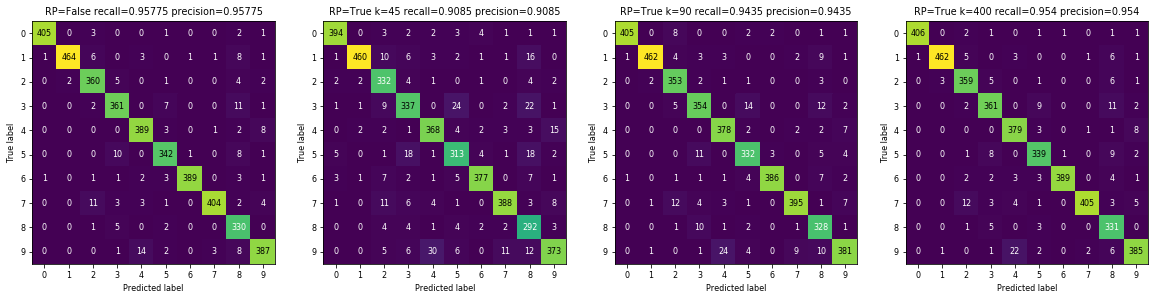

In [9]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# Split into train and test data
size = 16000
x_train, x_test, y_train, y_test = train_test_split(X[:size], y[:size])

# Plots
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

# Test default classifier
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print_results(y_pred, y_test, axes[0], False)

# d is the amount of features
d = len(X[0]) 

# Run all projection experiments
for k, testnr in zip([45, 90, 400], range(3)):
    R = generateMatrix(k, d)
    # Project data
    x_proj_train = random_projection(x_train, R)
    x_proj_test = random_projection(x_test, R)
    
    clf.fit(x_proj_train, y_train)
    y_pred = clf.predict(x_proj_test)
    print_results(y_pred, y_test, axes[testnr + 1], True, k)

#### Result
When looking at our results, we can note some very interesting details.
First off, we note that due to the random nature, the results may vary when attempting multiple runs. 

One global trend seems to be that when k is increased, the results get better. This is also what we expected after making the previous exercise. Most notably, in most cases when taking k=400, the results improve compared to the regular 1-NN classifier!

## PCA of a handwritten digits (7 points, 3+2+2)
Analyze the first two principal components of the class with label $4$ of the MNIST data set (those are images that each depict a handwritten "4"). Perfom the steps (a), (b), (c) described below. Note that these steps are similar to the analysis given in the lecture. Include all images and plots in your report. You may use sklearn.decomposition.PCA for this assignment. Do not scale the data.

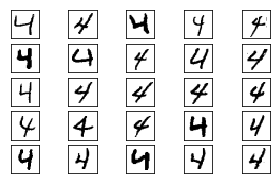

In [10]:
# build a list of figures on a 5x5 grid for plotting
def buildFigure5x5(fig, subfiglist):
    
    for i in range(0,25):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(5,5,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

# find the first 25 instances with label '4' and plot them
imgs = np.empty([25, 28*28], dtype='float')
j=0
for i in range(0,len(X)):
    if(y[i] == 4) and j < 25:
        imgs[j] = np.array(X[i], dtype='float')
        j += 1

buildFigure5x5(plt.figure(1),imgs)
plt.show()

### Step (a)
 Generate a scatter plot of the data in the space spanned by the first two principal components of PCA. Reconstruct $25$ points on a $5 \times 5$ grid in this space that cover the variation of the data. Render each point as an image. Arrange the images in a $5 \times 5$ grid.


In [11]:
def min_dist(A, b):
    lowest = 99999
    lowestI = 0
    lowestA = np.array((0,0))
#     A = A.reshape(-1,2)
    for a in range(len(A[0])):
        dist = np.linalg.norm(A[:,a]-b)
        if (dist < lowest):
            lowest = dist
            lowestA = A[:,a]
            lowestI = a
    return lowestA, lowestI

def buildFigure5x5v2(fig, subfiglist, titles):
    
    for i in range(0,25):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(5,5,i+1, title=titles[i])
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

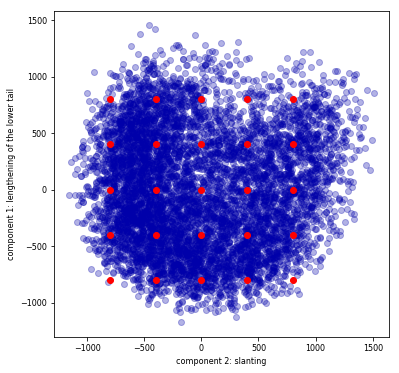

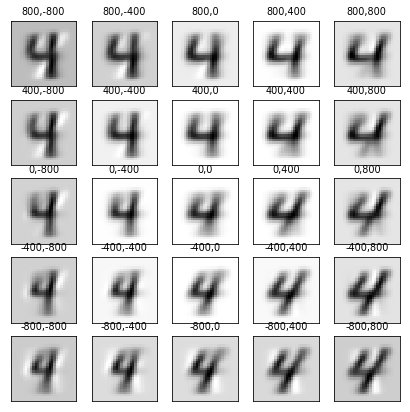

In [24]:
from sklearn.decomposition import PCA

fours = np.empty([6824, 28*28], dtype='float')
j = 0
for i in range(0,len(X)):
    if(y[i] == 4):
        fours[j] = np.array(X[i], dtype='float')
        j += 1

pca = PCA(n_components=2,svd_solver='full')
pcb = pca.fit_transform(fours)
# pcb = pca.transform(fours)

imgs = np.empty([25, 28*28], dtype='float')
original_imgs = np.empty([25, 28*28], dtype='float')
points = np.empty([25, 2], dtype='float')
original_points = np.empty([25, 2], dtype='float')
titles = np.empty([25],dtype='object')
plt.figure(figsize=(6,6))
p=0
parametersi = [800, 400, 0, -400, -800]
parametersj = [-800, -400, 0, 400, 800]
for i in parametersi:
    for j in parametersj:
        pcb0, l = min_dist(np.array((pcb[:,0], pcb[:,1])),np.array((i,j)))
        points[p] = np.array((i,j))
        titles[p] = "%d,%d" % (i,j)
        original_points[p] = pcb0
        imgs[p] = pca.mean_ + i*pca.components_[0] + j*pca.components_[1]
        original_imgs[p] = fours[l]#pca.mean_ + pcb0[0]*pca.components_[0] + pcb0[1]*pca.components_[1]
#         original_imgs[p] = pca.mean_ + pcb[l,0]*pca.components_[0] + pcb[l,1]*pca.components_[1]
        p += 1
    
plt.xlabel("component 2: slanting")
plt.ylabel("component 1: lengthening of the lower tail");  
plt.scatter(pcb[:,0], pcb[:,1], alpha=0.3)
plt.scatter(points[:,0], points[:,1], color='red' )
plt.show()
buildFigure5x5v2(plt.figure(1, figsize=(7,7)),imgs, titles)
plt.show()

### Step (b) 
For each of the reconstructed points, find the original instance that is closest to it in the projection on the first two components (measured using Euclidean distance). Render the instances arranged in a $5 \times 5$ grid such that their position matches the rendering in (a).


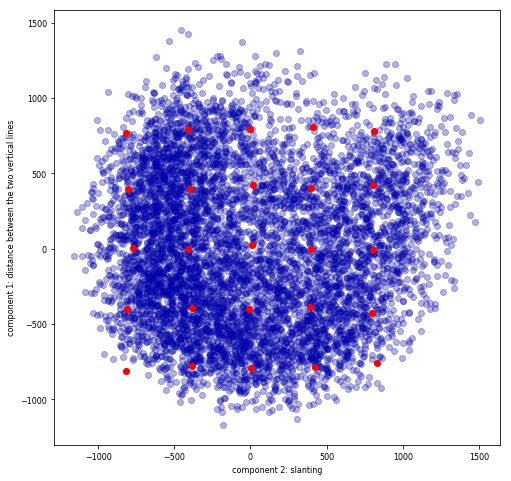

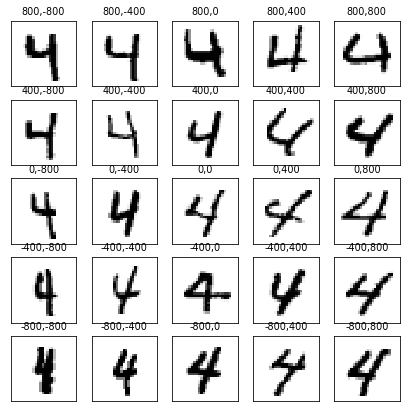

In [25]:
plt.figure(figsize=(8,8))
plt.xlabel("component 2: slanting")
plt.ylabel("component 1: distance between the two vertical lines");
plt.scatter(pcb[:,0], pcb[:,1], alpha=0.3)
plt.scatter(original_points[:,0], original_points[:,1], color='red' )
plt.show()
buildFigure5x5v2(plt.figure(1, figsize=(7,7)), original_imgs, titles)
plt.show()

### Step (c)
Render the mean and the first two principal components as images. What is your interpretation of the first two components, i.e., which aspect of the data do they capture? Justify your interpretation, also using your results of Steps (a) and (b).


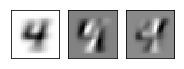

In [16]:
def buildFigure3x1(fig, subfiglist):
    
    for i in range(0,3):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(1,5,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

images = np.empty([3,28*28], dtype='float')
images[0] = pca.mean_
images[1] = pca.components_[0]
images[2] = pca.components_[1]
buildFigure3x1(plt.figure(1), images)
plt.show()

#### Results

Component 1 seems to be the distance between the 2 vertical lines of the 4. If you look at the 5x5 in step(a) and step(b), all the fours have a smaller gap between the 2 vertical lines the lower you go.
Component 2 seems to be the slanting of the number, which can clearly be seen by the most right picture above, where the 4 is clearly slanted. This can also be clearly seen in the 5x5 in step(a) and step(b) where the more you go to the right, the more slanted the numbers become (except perhaps for the top row).

## Projection onto a hyperplane (4 points)
Let $F$ be a $k$-dimensional hyperplane given by the parametric representation
$$ g(\lambda) = \mu + {\bf V} \lambda,$$
where $\mu \in \mathbb{R}^d$ and the columns of $\bf V$ are pairwise orthogonal and normal vectors $\bf v_1,\dots,v_k \in \mathbb{R}^d$.
Let $f:\mathbb{R}^d\rightarrow F$ be the projection that maps every point ${\bf p} \in \mathbb{R}^d$ to its nearest point on $F$ (where distances are measured using the Euclidean distance). We can also write $f$ as follows 
$$f({\bf p}) = g\left({\bf V}^T ({\bf p}-\mu)\right).$$

Prove that for any ${\bf p,q} \in \mathbb{R}^d$, it holds that
$$ \|f({\bf p})-f({\bf q})\| \leq \|{\bf p-q}\|. $$

(Hint: Assume first that $\mu=0$. Rewrite $f$ using a rotation followed by an orthogonal projection. What happens to the distance in each step? Generalize to arbitrary $\mu$.)


#### Proof
We assume first that $\mu = 0$. We then rewrite f as being a rotation $R$ followed by an orthogonal $P$ projection, from which follows:

$$ \|f({\bf p})-f({\bf q})\| = \| P(R({\bf p})) - P(R({\bf q}))\|$$

Since these operators are linear, we can state that: 
$$\| P(R({\bf p})) - P(R({\bf q}))\| = \| P(R({\bf p}-{\bf q}))\|$$

Additionally, rotation does not change the distance of the vectors, hence:
$$\| P(R({\bf p}-{\bf q}))\| = \| P({\bf p}-{\bf q})\|$$

Let us define a point ${\bf z} \in \mathbb{R}^d$ such that ${\bf z} = {\bf p}-{\bf q}$. We then get: 
$$\| P({\bf p}-{\bf q})\| = \| P({\bf z})\|$$

Clearly, whenever we orthogonally project a point from a dimension $d$ to a dimension $k$ with $k < d$ the distance can strictly decrease since all dimensions 'lost' effectively get a distance of zero. Therefore, we get that for any ${\bf p,q} \in \mathbb{R}^d$:
$$\| f({\bf p})-f({\bf q})\| = \| P({\bf z})\| \leq \| {\bf z}\| = \| {\bf p}-{\bf q}\|$$

Now if we no longer make an assumption on $\mu$ we get a similar reasoning, only now we define every point ${\bf p} \in \mathbb{R}^d$ to be equal to ${\bf p - \mu}$. Then our previous reasoning still holds, since $\mu \in \mathbb{R}^d$ and we can apply our previous proof.

## Locality-sensitive hashing (3 points, 1+2)

$H$ is a family of $(d_1,d_2,p_1,p_2)$-locality-sensitive hash functions if it holds that
\begin{align}
\text{if}\quad d({\bf p,q})\leq d_1 \quad &\text{then}& \quad \Pr\left[ h({\bf p})=h({\bf q})\right] \geq p_1 \quad \\
\text{if}\quad d({\bf p,q})\geq d_2 \quad &\text{then}& \quad \Pr\left[ h({\bf p})=h({\bf q})\right] \leq p_2 \quad
\end{align}

### Case: $p_2=0$
Assume that $p_2=0$ and assume we have a total numer of $m$ hash
functions from this family available.  Which combination of AND-constructions
and OR-constructions should we use to amplify the hash family?



### Case: $p_2=\frac{1}{n}$
Now assume that $p_2=\frac{1}{n}$ and assume we have $n$ data points $\bf P$
which are stored in a hash table using a randomly chosen function $h$ from $H$.
Given a query point $\bf q$, we retrieve the points in the hash bucket with index $h(\bf q)$ to search 
for a point which has small distance to $\bf q$. 
Let $X$ be a random variable that is equal to the size of the set 

\begin{align}
\left\{{\bf p \in P}\,:\, h({\bf p})=h({\bf q}) \,\wedge\, d({\bf p,q}) \geq d_2\right\}\
\end{align}

which consists of the false positives of this query.

Derive an upper bound on the expected number of false-positives $\mathbb{E}\left[ X \right]$ using $p_2$. Explain each step of your derivation.